## Infrequent MetaD analysis

In [1]:
#libraries needed
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.misc import factorial
from scipy.stats import ks_2samp
from scipy import stats
import os, sys

In [2]:
datain=np.genfromtxt('250stride1.csv',delimiter=',')
data=datain[:,1]*1e9
#rint np.size(data)
#data now in "ns for each escape event
min=np.min(data)
max=np.max(data)
bins=10*np.size(data)

#logscale of times
time=np.logspace(np.log10(min),np.log10(max),num=bins)
mu=np.mean(data)

#print time
time_centers = np.r_[0.5 * (time[:-1] + time[1:])]
#print time_centers
#this is because MATLAB works on the bin centers, numpy works on the bin edges

In [3]:
def analyticalCDF(times,tau):
    return 1-np.exp(-times/tau)
    

In [4]:
#Make histogram and CDF
hist, bins2=np.histogram(data,bins=time,density=False)
cdf=np.cumsum(hist)*1.0/data.size


In [5]:
taufit, pcov = curve_fit(analyticalCDF,time_centers, cdf,mu)
print "mu (ns)\t\t" ,mu
print "taufit (ns)\t" ,taufit[0]

mu (ns)		3.21596365826e+14
taufit (ns)	2.45497458971e+14


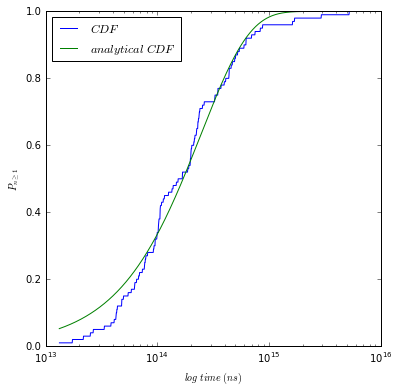

In [6]:
#lets make some plots
%matplotlib inline 
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

axes = fig.add_subplot(111)
axes.plot(bins2[1:bins],cdf,label='$CDF$')
axes.set_xscale('log')
axes.plot(time_centers,analyticalCDF(time_centers,taufit),label='$analytical\ CDF$')
first_legend = plt.legend(loc=0)
axes.set_xlabel('$log\ time\ (ns)$')
axes.set_ylabel('$P_{n\geq1}$')
plt.show()

In [7]:
#generate  random data points from the analytical fit based on taufit
points=1e5
randdata=np.random.gamma(1,taufit,np.size(data)*points)

#perfrom the KS test to see if the data points from MetaD are statistically
#the same as the data points from the analytical fit
stat,p=ks_2samp(data,randdata)

/Users/chrisfu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [8]:
#data table: 
print "mu:" , np.mean(data)
print "mu_sem:", stats.sem(data)
print "sigma:", np.std(data,ddof=1) 
print "t_m:", np.median(data)
print "tau:", taufit
print "mu_sigma_ratio:", np.mean(data)/np.std(data,ddof=1)
print "log2mu_median_ratio:", np.log(2)*np.mean(data)/np.median(data)
print "tau_mu_ratio:", taufit/np.mean(data)
print "p-value:" , p
print "ks-stat:" , stat
print "events recorded:" ,  np.size(data)

mu: 3.21596365826e+14
mu_sem: 6.3079288399e+13
sigma: 6.3079288399e+14
t_m: 1.60345337639e+14
tau: [  2.45497459e+14]
mu_sigma_ratio: 0.509828778968
log2mu_median_ratio: 1.39020951612
tau_mu_ratio: [ 0.76337137]
p-value: 0.422940702914
ks-stat: 0.0867247
events recorded: 100


###Sampling

In [9]:
##random sampling on data set
def sampling(data, num_iters, sampsize):

    means = np.array([0.0])
    pvals = np.array([0.0])
    test1 = np.array([0.0])      # statistic test1: mu_sigma_ratio
    test2 = np.array([0.0])   # statistic test2: log2mu_median_ratio 
    
    points = 1e4  # number of sampling points for p-val
    alpha = 0.05
    reject = 0.0
   
    while np.size(means) <= num_iters: 
        if reject == num_iters:
            break
        
        smalldata=np.random.choice(data, sampsize, replace=True)
        # hist / CDF fit / etc
        min = np.min(smalldata)
        max = np.max(smalldata)
        bins = 10*np.size(smalldata)
        time = np.logspace(np.log10(min), np.log10(max), num=bins)
        
        mu = np.mean(smalldata)
        sigma = np.std(smalldata, ddof=1) 
        t_m = np.median(smalldata)
        
        time_centers = np.r_[0.5 * (time[:-1] + time[1:])]
        hist, bins2 = np.histogram(smalldata, bins=time, density=False)
        cdf = np.cumsum(hist)*1.0/smalldata.size
        taufit, pcov = curve_fit(analyticalCDF, time_centers, cdf, mu)
        # analysis 
        randdata = np.random.gamma(1, taufit, np.size(data)*points)
        stat, p = ks_2samp(smalldata, randdata)
        if p > alpha:
            means[means.size-1] = mu
            pvals[pvals.size-1] = p
            test1[test1.size-1] = mu/sigma
            test2[test2.size-1] = np.log(2)*mu/t_m
            
            # debugprint p, mu
            means.resize(means.size+1)
            pvals.resize(pvals.size+1)
            test1.resize(test1.size+1)
            test2.resize(test2.size+1)
            
        if p < alpha:
            reject=reject+1
            
    # this is just book keeping to remove the last 0 element
    means = means[:(means.size-1)]
    pvals = pvals[:(pvals.size-1)]
    mu_sigma_ratio = test1[:(test1.size-1)]
    log2mu_median_ratio = test2[:(test2.size-1)]
    
        
    return means, pvals, reject, mu_sigma_ratio, log2mu_median_ratio

In [ ]:
filename = [x for x in os.listdir('.') if x[-4:] == '.txt']
filename

iteration 2000
250stride1.csv
mu: 323133607911.0 123934219698.0
p-value 0.582500179683 0.244954948326
mu_sigma_ratio: 0.800438291161 0.30450622644
log2mu_median_ratio: 1.44684485241 0.582274818999
15.0


/Users/chrisfu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


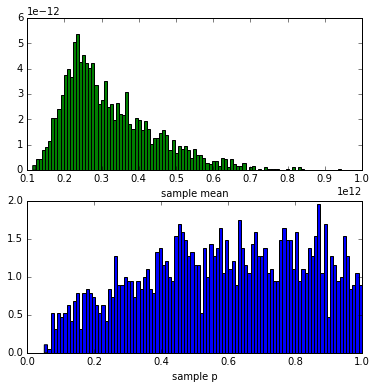

iteration 2000
250stride2.csv
mu: 383815451833.0 120789024929.0
p-value 0.544050322075 0.248719686942
mu_sigma_ratio: 0.75042592888 0.207316034405
log2mu_median_ratio: 1.4761764023 0.510512271862
20.0


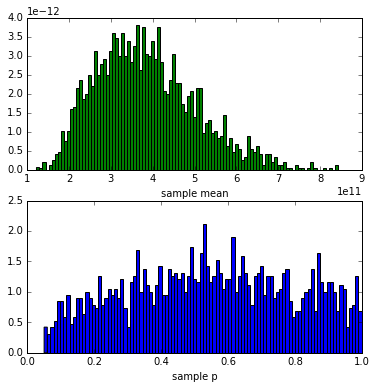

iteration 2000
250stride3.csv
mu: 509533183768.0 165263749811.0
p-value 0.431593328318 0.236123291372
mu_sigma_ratio: 0.746438520179 0.177703597028
log2mu_median_ratio: 1.68341665581 0.537245665719
56.0


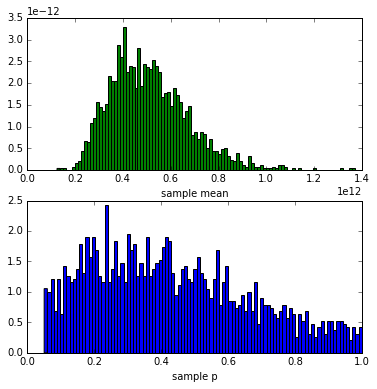

iteration 2000
250stride4.csv
mu: 379504374973.0 150311276417.0
p-value 0.501797035231 0.239879297229
mu_sigma_ratio: 0.751188491202 0.260789453138
log2mu_median_ratio: 1.58116210996 0.668922515867
23.0


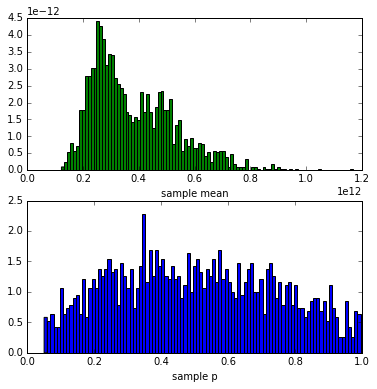

iteration 2000
250stride5.csv
mu: 329018332052.0 124622241103.0
p-value 0.670108899739 0.245158113084
mu_sigma_ratio: 0.824931361044 0.309417678119
log2mu_median_ratio: 1.34860802826 0.530673024304
8.0


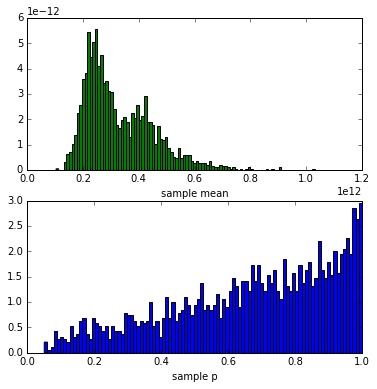

iteration 2000
250stride6.csv
mu: 389401207789.0 158511526809.0
p-value 0.575220518549 0.252983344339
mu_sigma_ratio: 0.738621512517 0.273082996813
log2mu_median_ratio: 1.56841395688 0.643775754557
15.0


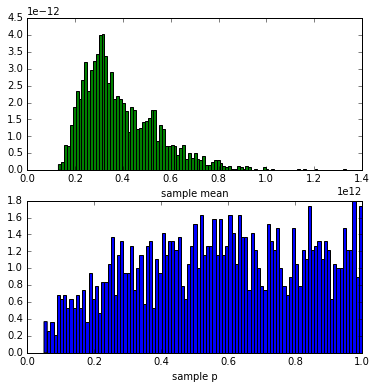

iteration 2000
250stride7.csv
mu: 292606808908.0 91966998215.2
p-value 0.600627718186 0.236998298584
mu_sigma_ratio: 0.775626704804 0.200526399455
log2mu_median_ratio: 1.50322241354 0.504978392754
5.0


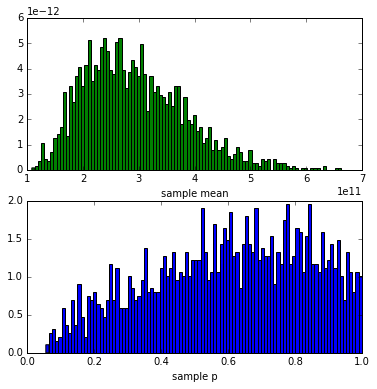

iteration 2000
250stride8.csv
mu: 323472162291.0 82596895009.7
p-value 0.595101164138 0.256705064757
mu_sigma_ratio: 0.891128100133 0.209677662325
log2mu_median_ratio: 1.21960832748 0.296197792575
16.0


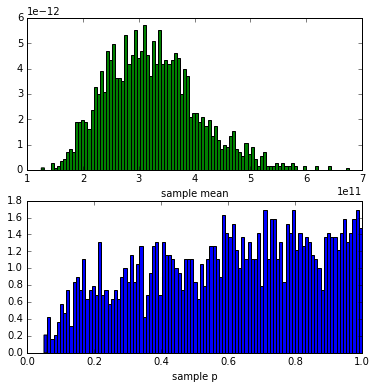

iteration 2000
250stride9.csv
mu: 234533925112.0 65451825223.9
p-value 0.498023088589 0.249728969865
mu_sigma_ratio: 0.872432420148 0.252257838594
log2mu_median_ratio: 1.22536425622 0.317204745921
24.0


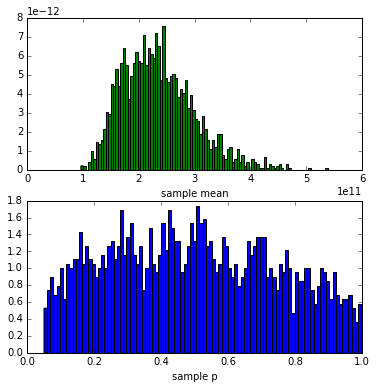

iteration 2000
250stride10.csv
mu: 389975626688.0 161144620994.0
p-value 0.56977657168 0.251263792509
mu_sigma_ratio: 0.772229926278 0.255338267954
log2mu_median_ratio: 1.51402076528 0.707334246115
21.0


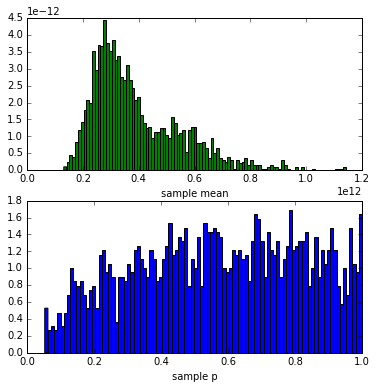

In [10]:
%matplotlib inline 
niter = 2000
samplesize = 25   # ex: 40 choose 25
filename=['250stride1.csv','250stride2.csv','250stride3.csv','250stride4.csv','250stride5.csv','250stride6.csv','250stride7.csv','250stride8.csv','250stride9.csv','250stride10.csv']

results={}
for name in filename:
    datain = np.genfromtxt(name,delimiter=',')
    data = datain[:, 1]*1e6    # microsecond
    means, pvals, reject, mu_sigma_ratio, log2mu_median_ratio = sampling(data, niter, samplesize)
    
    if reject == niter:
        print name
        print "All rejected"
        continue

    
    results[name] = [np.mean(means), np.std(means), np.mean(pvals), np.std(pvals),
                     np.mean(mu_sigma_ratio), np.std(mu_sigma_ratio), np.mean(log2mu_median_ratio), 
                     np.std(log2mu_median_ratio), reject]

    print "iteration", len(means)
    print name
    print "mu:", np.mean(means), np.std(means)
    print "p-value", np.mean(pvals), np.std(pvals) 
    print "mu_sigma_ratio:", np.mean(mu_sigma_ratio), np.std(mu_sigma_ratio)
    print "log2mu_median_ratio:", np.mean(log2mu_median_ratio), np.std(log2mu_median_ratio)
    print reject
    
    
    fig = plt.figure(figsize=(6,6))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=0.2)
    axes = fig.add_subplot(211)

    plt.hist(means, bins=100, color='green', normed=True, label='sample means')
    axes.set_xlabel('sample mean')
    #axes.set_ylabel('count')
    
    axes = fig.add_subplot(212)
    plt.hist(pvals, bins=100, color='blue', normed=True, label='sample p')
    axes.set_xlabel('sample p')
    #axes.set_ylabel('count')
    plt.show()


In [ ]:
results

In [ ]:
#Rejecting rate
for i in results.values():
    print i[-1], i[-1]/(2000+i[-1])